## Clean and geocode scraped places from Google Maps

In [117]:
import os
import sys
import pandas as pd
import numpy as np
import re
import time
import geopandas as gpd

# geocoding
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [96]:
# read in two scraped datasets
conference_centers = pd.read_csv('conference_centers.csv')
event_spaces = pd.read_csv('event_spaces.csv')

conference_centers.head(2)

,gmapsurl,name,stars,nreviews,type,address,closingtime,businesspic,comment
0,https://www.google.com/maps/place/McCormick+Pl...,McCormick Place,4.5,"-13,051",Convention center,2301 S Martin Luther King Dr,⋅ Closes 10 PM,https://lh5.googleusercontent.com/p/AF1QipNWSI...,"""Huge conference center."""
1,https://www.google.com/maps/place/Together+by+...,Together by Hyatt,NaN,NaN,Convention center,151 E Wacker Dr,NaN,https://streetviewpixels-pa.googleapis.com/v1/...,NaN


In [97]:
# Initialize the geocoder
geolocator = Nominatim(user_agent="my_unique_user_agent")

def lambda_geocode(address, max_retries=3):
    retries = 0
    while retries < max_retries:
        try:
            location = geolocator.geocode(address, timeout=10)
            time.sleep(1)  # Sleep for 1 second between requests
            return location
        except GeocoderUnavailable:
            retries += 1
            time.sleep(2)  # Sleep for 2 seconds before retrying
    return None  # Return None if all retries fail

def geocode_address(df):
    # Geocode addresses
    df['Location'] = df['address'].apply(lambda_geocode)

    # Extract latitude and longitude
    df['lat'] = df['Location'].apply(lambda loc: loc.latitude if loc else None)
    df['lon'] = df['Location'].apply(lambda loc: loc.longitude if loc else None)

    # Drop the Location column
    df.drop('Location', axis=1, inplace=True)

    return df


def clean_data(df):

    # check if nreviews column is type string
    if  df['nreviews'].dtype == 'str' or df['nreviews'].dtype == 'object':
        # convert to numeric
        df.loc[:, 'nreviews'] = pd.to_numeric(df['nreviews'].str.replace(',', ''))

    df = df.dropna(subset=['stars', 'nreviews'])
        

    # multiple nreviews by -1
    df.loc[:, 'nreviews'] = df['nreviews'] * -1
    # convert to int
    df.loc[:, 'nreviews'] = df['nreviews'].astype(int)

    # drop rows with nan in nreviews
    df = df.dropna(subset=['nreviews'])

    # clean all non numeric or alphabetic characters from the closingtime column
    df.loc[:, 'closingtime'] = df['closingtime'].str.replace(r'⋅ ', '')

    # append "Chicago, IL" to the end of the address column
    df.loc[:, 'address'] = df['address'] + ', Chicago, IL'

    # remove quote marks from comment
    df.loc[:, 'comment'] = df['comment'].str.replace('"', '')

    # return
    return df

# clean both datasets
conf_cleaned = clean_data(conference_centers)
event_cleaned = clean_data(event_spaces)


# show cleaned data
conf_cleaned.head()

,gmapsurl,name,stars,nreviews,type,address,closingtime,businesspic,comment
0,https://www.google.com/maps/place/McCormick+Pl...,McCormick Place,4.5,13051,Convention center,"2301 S Martin Luther King Dr, Chicago, IL",Closes 10 PM,https://lh5.googleusercontent.com/p/AF1QipNWSI...,Huge conference center.
2,https://www.google.com/maps/place/Merchandise+...,Merchandise Mart Conference Hall,4.7,179,Conference center,"222 W Merchandise Mart Plaza, Chicago, IL",NaN,https://lh5.googleusercontent.com/p/AF1QipN1QU...,Nice exhebition center
3,https://www.google.com/maps/place/Lawndale+Chr...,Lawndale Christian Health Center Skyline Confe...,4.8,12,Conference center,"3750 West, W Ogden Ave 4th Floor, Chicago, IL",Closes 9 PM,https://lh5.googleusercontent.com/p/AF1QipNqK5...,NaN
4,https://www.google.com/maps/place/McCormick+Pl...,"McCormick Place Lakeside Center, East Building",4.4,294,Convention center,"2301 S DuSable Lake Shore Dr, Chicago, IL",Closes 12 AM,https://lh5.googleusercontent.com/p/AF1QipOHH4...,Nice convention center
6,https://www.google.com/maps/place/American+Air...,American Airlines Conference Center,4.7,24,Conference center,"1101 W Waveland Ave f2, Chicago, IL",Closes 10 PM,https://lh5.googleusercontent.com/p/AF1QipNJgj...,NaN


In [98]:
# attempt to geocode the addresses
conf_geocoded = geocode_address(conf_cleaned)

In [99]:
# attempt to geocode event spaces
event_geocoded = geocode_address(event_cleaned)

In [103]:
# drop Unnamed 9 and Unnamed 10 columns from event_geocoded
event_geocoded = event_geocoded.drop(['Unnamed: 9', 'Unnamed: 10'], axis=1)
event_geocoded.head(1)

,gmapsurl,name,stars,nreviews,type,address,closingtime,businesspic,comment,lat,lon
0,https://www.google.com/maps/place/Loft+Lucia/d...,Loft Lucia,4.7,213.0,Event venue,"7 N Carpenter St, Chicago, IL",Closes 12 AM,https://lh5.googleusercontent.com/p/AF1QipOfdr...,Loft Lucia was a fantastic space for our,41.881895,-87.65309


In [138]:
# merge the two datasets
merged = pd.concat([conf_geocoded, event_geocoded])

# identify outliers in lat/lon
mean_lat = merged['lat'].mean()
std_lat = merged['lat'].std()
mean_lon = merged['lon'].mean()
std_lon = merged['lon'].std()

# remove outliers
nrow_original = merged.shape[0]
merged = merged[(merged['lat'] > mean_lat - 1 * std_lat) & (merged['lat'] < mean_lat + 1 * std_lat)]
merged = merged[(merged['lon'] > mean_lon - 1 * std_lon) & (merged['lon'] < mean_lon + 1 * std_lon)]
print(f"Removed {nrow_original - merged.shape[0]} outliers based on latitude/longitude outliers")

Removed 34 outliers based on latitude/longitude outliers


In [139]:



# drop if lat or lon is null
merged = merged.dropna(subset=['lat', 'lon'])

# drop any type that exists less than 4 times
merged = merged.groupby('type').filter(lambda x: len(x) > 3)

# print value counts of type
print( merged['type'].value_counts() )

# add integer id column
merged['id'] = range(1, len(merged) + 1)

# move these columns to front: ['id', 'name', 'address', 'type', 'stars', 'nreviews', 'closingtime', 'comment', 'lat', 'lon']
cols = ['id', 'name', 'address', 'type', 'stars', 'nreviews', 'closingtime', 'comment', 'lat', 'lon', 'gmapsurl', 'businesspic']
merged = merged[cols]

#
merged.head()

type
Event venue          38
Conference center    31
Convention center    17
4-star hotel          6
Name: count, dtype: int64


,id,name,address,type,stars,nreviews,closingtime,comment,lat,lon,gmapsurl,businesspic
0,1,McCormick Place,"2301 S Martin Luther King Dr, Chicago, IL",Convention center,4.5,13051,Closes 10 PM,Huge conference center.,41.748530,-87.614897,https://www.google.com/maps/place/McCormick+Pl...,https://lh5.googleusercontent.com/p/AF1QipNWSI...
2,2,Merchandise Mart Conference Hall,"222 W Merchandise Mart Plaza, Chicago, IL",Conference center,4.7,179,NaN,Nice exhebition center,41.888180,-87.635064,https://www.google.com/maps/place/Merchandise+...,https://lh5.googleusercontent.com/p/AF1QipN1QU...
4,3,"McCormick Place Lakeside Center, East Building","2301 S DuSable Lake Shore Dr, Chicago, IL",Convention center,4.4,294,Closes 12 AM,Nice convention center,41.810972,-87.589469,https://www.google.com/maps/place/McCormick+Pl...,https://lh5.googleusercontent.com/p/AF1QipOHH4...
7,4,Gleacher Center,"450 Cityfront Plaza Dr, Chicago, IL",Conference center,4.7,496,Closes 12 AM,Great conference center!,41.890322,-87.621484,https://www.google.com/maps/place/Gleacher+Cen...,https://lh5.googleusercontent.com/p/AF1QipPYCI...
9,5,Puerto Convention Center,"150 N Wacker Dr # 1740, Chicago, IL",Convention center,5.0,2,NaN,NaN,41.884685,-87.637363,https://www.google.com/maps/place/Puerto+Conve...,https://lh5.googleusercontent.com/p/AF1QipOiwZ...


In [140]:
# Save to cleaned directory

saved_dir = os.path.join('..', 'cleaned')
if not os.path.exists(saved_dir):
    os.makedirs(saved_dir)

# save to csv
merged.to_csv(os.path.join(saved_dir, 'event_spaces_cleaned.csv'), index=False)


In [146]:
# convert to geodf
gdf = gpd.GeoDataFrame(merged, geometry=gpd.points_from_xy(merged.lon, merged.lat))

# Set the coordinate reference system (CRS) to EPSG 3435 - State Plane Coordinate System for Illinois East
gdf.crs = {'init': 'epsg:3435'}

# save to shapefile in a shapefile folder
shapefile_dir = os.path.join('..', 'cleaned', 'events_shapefile')
if not os.path.exists(shapefile_dir):
    os.makedirs(shapefile_dir)


# rename closingtime to close_time, and businesspic to biz_pic (10 char limit)
gdf = gdf.rename(columns={'closingtime': 'close_time', 'businesspic': 'biz_pic'})

gdf.to_file(os.path.join(shapefile_dir, 'event_spaces.shp'))


/Users/coltonlapp/anaconda3/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


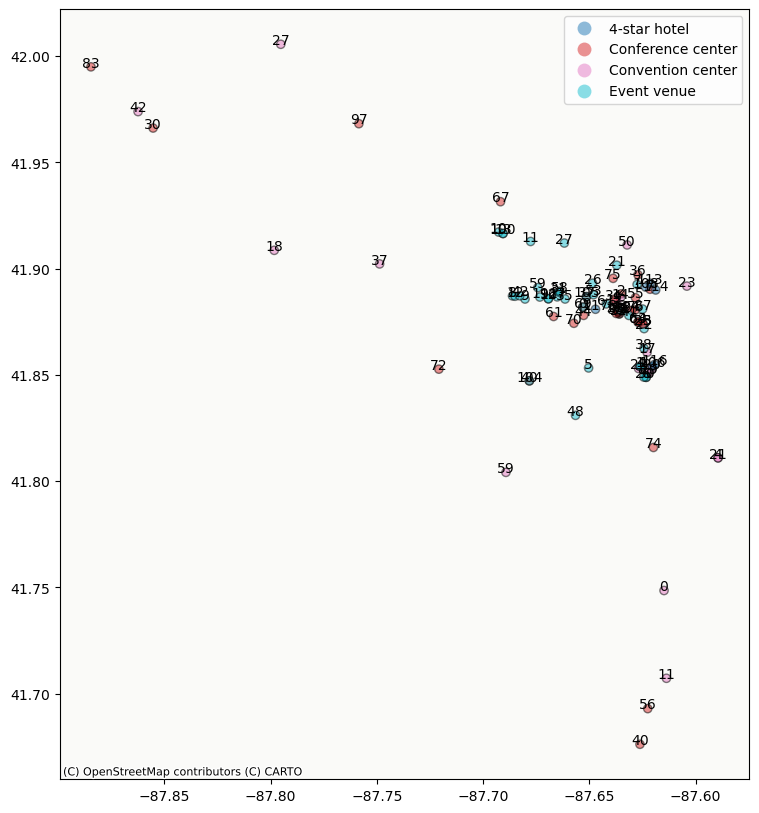

In [153]:
# plot gdf with open street map basemap underneath
import contextily as ctx
import matplotlib.pyplot as plt

# plot with name as label
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', column='type', legend=True)

# add text label over points with text from "name" column

# add basemap that isn't mapnik
map_crs = 'EPSG:3435'
ctx.add_basemap(ax, crs=map_crs, source=ctx.providers.CartoDB.Positron, zoom = 1)

gdf.apply(lambda x: ax.annotate(text=x.name, xy=x.geometry.coords[0], ha='center'), axis=1)
plt.show()
